In [7]:
# import necessary packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import mevpy as mev # only works when this "Mevpy" folder is in the folder of this .ipnyb-file (https://github.com/EnricoZorzetto/mevpy)
import warnings
import random
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib as mpl

import os

In [8]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

Load in aggregated data:

In [13]:
df_all_data = pd.read_parquet(f"{data_folder}\\combined_data.parquet")
df_all_data.head()

,pan_E,P,Q
index,,,
1961-01-01,6.571429,NaN,NaN
1961-01-02,7.285714,NaN,NaN
1961-01-03,6.428571,NaN,NaN
1961-01-04,9.285714,NaN,NaN
1961-01-05,7.571429,NaN,NaN


In [122]:
prcp_df = df_all_data[["P"]].dropna()
prcp_df.rename(columns={"P":"PRCP"},inplace=True)
prcp_df = prcp_df[prcp_df.index >  pd.Timestamp("1892-08-01")] # skip gap in data

In [144]:
def annual_maxima(data):
    idx_max = data.groupby(data.index.year)['PRCP'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

In [145]:
df_prcp_maxima = annual_maxima(prcp_df).sort_values("PRCP",ascending=False)
df_prcp_maxima.index.name = "time"
df_prcp_maxima.head()

,PRCP,YEAR
time,,
2010-10-01,91.771429,2010
2011-08-29,71.637838,2011
1932-10-06,68.831034,1932
1983-04-08,66.851515,1983
1948-12-31,65.988462,1948


<AxesSubplot: xlabel='time'>

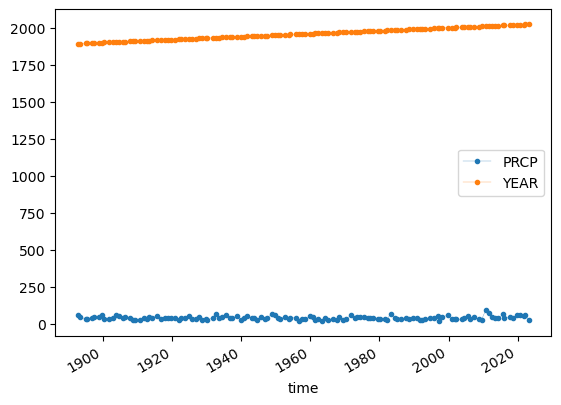

In [146]:
df_prcp_maxima.plot(marker=".",lw=0.2)

In [147]:
#exercise, calculate N and expand you annual maxima dataframe with the columns i, p, q, y, T_a
M = len(df_prcp_maxima)

# indexing tricks to obtain i 
df_prcp_maxima_ranked = df_prcp_maxima.copy().reset_index().reset_index()
df_prcp_maxima_ranked.set_index("time", inplace=True)
df_prcp_maxima_ranked['i'] = df_prcp_maxima_ranked.apply(lambda x: int(x['index']) + 1, axis=1)
df_prcp_maxima_ranked.drop(columns=['index'],inplace=True)

# use i to obtain p
df_prcp_maxima_ranked['p'] = df_prcp_maxima_ranked.apply(lambda x: int(x.i) / (M+1), axis=1)
# q = 1-p
df_prcp_maxima_ranked['q'] = df_prcp_maxima_ranked.apply(lambda x: 1 - x.p, axis=1)

# to compute y = -ln(-ln(q))
df_prcp_maxima_ranked['y'] = df_prcp_maxima_ranked.apply(lambda x: -np.log(-np.log(x.q)), axis=1)

# obtain T_a with 1/p 
df_prcp_maxima_ranked['T_a'] = df_prcp_maxima_ranked.apply(lambda x: 1 / x.p, axis=1)

In [148]:
# exercise: compute Gumbel parameters (name them sigma and mu)
s_R = annual_maxima_df_sorted['PRCP'].std()
s_y = annual_maxima_df_sorted['y'].std()
y_gem = annual_maxima_df_sorted['y'].mean()
R_max_gem = annual_maxima_df_sorted['PRCP'].mean()

sigma = s_R / s_y
mu = R_max_gem - s_R * y_gem / s_y

print(f'scale parameter σ =  {sigma:.3f}')
print(f'location parameter µ = {mu:.3f}')

scale parameter σ =  9.601
location parameter µ = 34.577


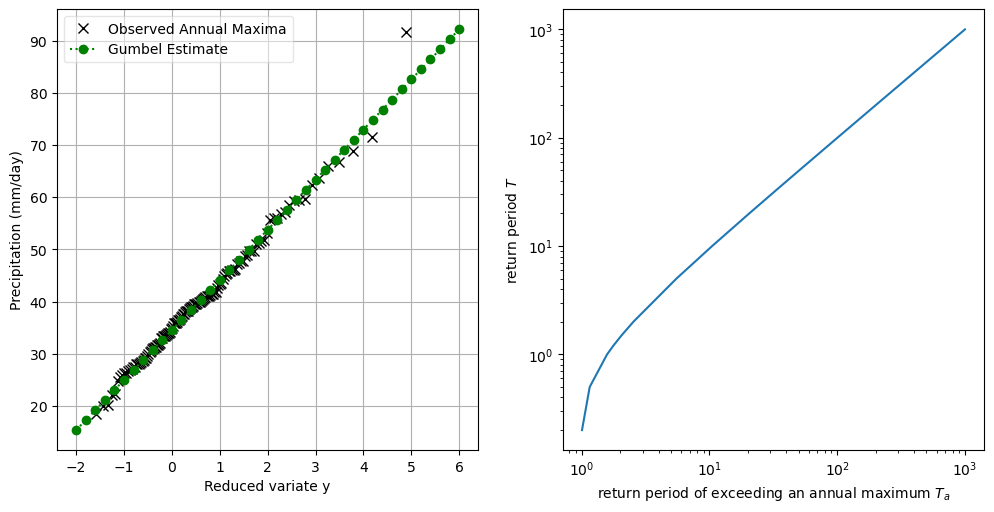

In [149]:
# Now we can construct the Gumbel fit and plot the Gumbel line
dummy_y = np.arange(-2,6.01,0.2)
R_Gumbel = sigma * dummy_y + mu

fig, [ax,ax2] = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(w_pad=3)

ax.plot(annual_maxima_df_sorted['y'].values, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(dummy_y, R_Gumbel, \
        ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500, 1000])
T_a_interest = 1 / (1-np.exp(-1/T_interest))
ax2.loglog(T_a_interest,T_interest)
ax2.set_xlabel('return period of exceeding an annual maximum $T_a$')
ax2.set_ylabel('return period $T$')

# real return period for the observed annual maxima
# T_a = 1 / p
# annual_maxima_df_sorted.loc[:,'T_a'] = T_a
# T = -1 / np.log(1 - 1/annual_maxima_df_sorted['T_a'].values)
# annual_maxima_df_sorted.loc[:,'T'] = T
annual_maxima_df_sorted['T'] = df_prcp_maxima_ranked.apply(lambda x: -1 / np.log(1 - (1/ x["T_a"])), axis=1)


In [150]:
gumbel_estimate = sigma * (- np.log(1/T_interest)) + mu
T = annual_maxima_df_sorted['T'].values

In [151]:
# fit GEV parameters (withhout overwriting the sigma and mu from Gumbel)
AMS = annual_maxima_df_sorted['PRCP'].values
xi, sigma_gev, mu_gev = mev.gev_fit(AMS)

F_interest = np.exp(-(1/T_interest))*(1/T_interest)**0

# calculate the GEV estimate for our return periods of interest
gev_estimate = mev.gev_quant(F_interest, xi, sigma_gev, mu_gev)

# convert to dataframe and make a nice table
df_gev_estimate = pd.DataFrame(gev_estimate,columns=['GEV estimate (mm/day)'])
df_gev_estimate.index = T_interest # Return Period

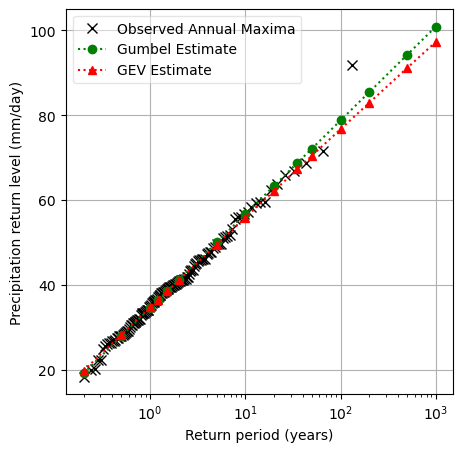

In [152]:
# create the figure
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
# ax.plot(T_interest[:-4], full_series, ':Pb', markersize=7, label = 'Full series')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

### both seem a fairly smooth fit, continue with MEV

In [153]:
prcp_df["YEAR"] = prcp_df.index.year

In [154]:
# fit mev parameters for each year
N, C, W =  mev.mev_fit(prcp_df, threshold=1)

# put this into a nice dataframe
df_params_mev = pd.DataFrame([N,C,W]).transpose()
df_params_mev.columns = ['N','C','W']
df_params_mev.head(10)

,N,C,W
0,29.0,14.591010,1.064731
1,152.0,7.749997,0.996807
2,140.0,7.927426,1.148148
3,114.0,8.247097,1.048815
4,123.0,7.908044,1.042873
5,168.0,6.955995,1.025442
6,179.0,6.991195,1.134152
7,138.0,6.713275,1.073682
8,152.0,6.380938,1.000065
9,158.0,6.818822,1.156472


In [155]:
# exercise: create your own code for plotting the CDF curves
dummy_X = np.arange(0,1000,2)

# non-exceedance probability for individual years (here defined as H)
H = np.zeros((len(dummy_X),M))
zeta = np.zeros((len(dummy_X)))

# continue with your own code here:
for i in range(len(zeta)):
    x = dummy_X[i]
    lst = []
    for j in range(len(W)):
        lst.append((1 - np.exp(-(x/C[j])**W[j]))**N[j])
    zeta[i] = 1 / M * np.sum(lst)
    
# x = dummy_X[0]
for j in range(M):
    for i in range(len(H)):
        x = dummy_X[i]
        H[i,j] = (1 - np.exp(-(x/C[j])**W[j]))**N[j]


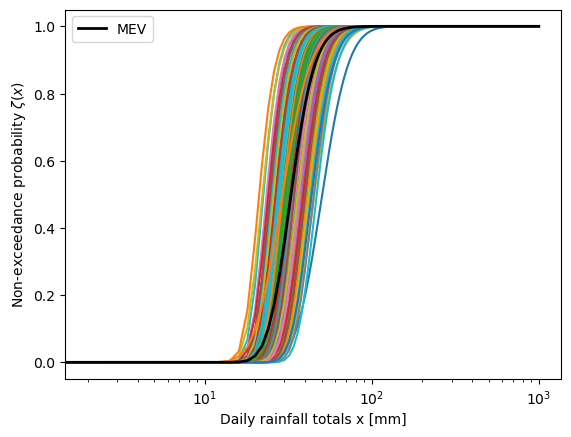

In [156]:
# plot figure like in Enrico's paper
fig, ax = plt.subplots()
ax.plot(dummy_X, H)
ax.plot(dummy_X, zeta, 'k', linewidth=2, label='MEV')
ax.set_xlabel('Daily rainfall totals x [mm]')
ax.set_ylabel('Non-exceedance probability $\zeta(x)$')
ax.set_xscale('log')
ax.legend()

In [157]:
# exercise, obtain the MEV solution
x0 = np.mean(AMS)
mev_estimate, flags =  mev.mev_quant(F_interest, x0, N, C, W)

if any(flags) == True:
    print('Change starting guess for the numerical solution x0')
elif any(flags) == False:
    print('No errors have been raised, continue the exercise')

No errors have been raised, continue the exercise


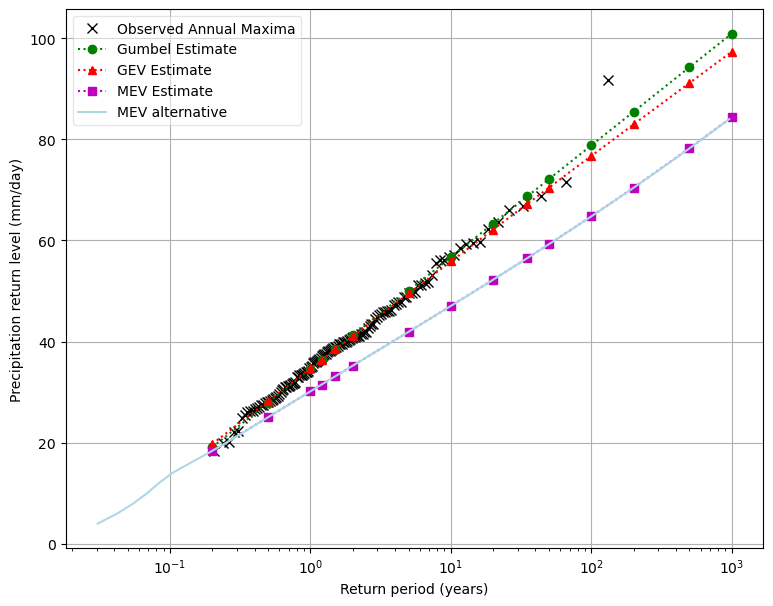

In [158]:
# bonus: with MEV alternative:
# return periods for the CDF curves
Ta_c = 1/(1-zeta)
T_c  = -1/(np.log(1-(1/Ta_c)))

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
mask = (T_c<1100) & (T_c > 0)
ax.plot(T_c[mask], dummy_X[mask], 'lightblue', label='MEV alternative')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

In [159]:
# The following code could be used as a starting point:
ntimes     = 500
nyears     = 10
# Tx         = 100 # the return period of interest
# Fx         = np.exp(-(1/Tx))*(1/Tx)**0  # non-exceedence probability of interest 
#                                         #- remember what we did in the beginning of this exercise

# empty variables for the GEV and MEV testcase estimates. 
# also, for the MEV function you need the variable 'flags', for the starting point of the numerial solution
# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500, 1000])
F_interest = np.exp(-(1/T_interest))*(1/T_interest)**0
# print(F_interest)
flags_test = 0
concat_lst = []

# create a loop that runs ntimes (e.g. a while-loop or a for-loop)
for i in range(ntimes):
    gev_test   = []
    mev_test   = []
        # print(Fx)
    # randomly select nyears from the years in your data. The function 'random.sample' could be used for this
    all_years = list(prcp_df["YEAR"].unique())
    selected_years = random.sample(all_years, k=10)
    for Fx in F_interest:
        ##### GEV #####
        # calculate the GEV estimate for these ten years:
        # 1 - randomly select 10 years from the AMS series created in 2
        mask_lst = []
        for index, yr in enumerate(selected_years):
            mask_lst.append(prcp_df[prcp_df["YEAR"] == selected_years[index]])
        selected_data_df = pd.concat(mask_lst)
        # get the maxima 
        selected_data_df_max = annual_maxima(selected_data_df)
        selected_data_df_max.sort_values("PRCP",inplace=True, ascending=False)
        # print(selected_data_df_max)
        # 2 - fit the three GEV parameters
        xi, sigma_gev, mu_gev = mev.gev_fit(selected_data_df_max['PRCP'].values)

        # 3 - calculate the GEV estimate 
        gev_estimate = mev.gev_quant(Fx, xi, sigma_gev, mu_gev)
        # print(gev_estimate)
        # save the gev estimate
        gev_test.append(gev_estimate)
 
        ##### MEV #####
        # calculate the MEV estimate for these ten years
        # 1 - randomly select 10 sets of MEV parameters (N,C and W for the same year) created above
        lst_index_selected_years = []
        for s_yr in selected_years:
            lst_index_selected_years.append(all_years.index(s_yr))
        lisy = sorted(lst_index_selected_years)
        
        # 2 - give a starting point for the numerical solution (x0).
        x0_i = np.mean(selected_data_df["PRCP"].values)

        # 3 - calculate the MEV estimate: mev_test_i, flag = mev.mev_quant(Fx, x0_i, N[...], C[...], W[...])
        mev_estimate, flag =  mev.mev_quant(Fx, x0_i, N[lisy], C[lisy], W[lisy])
        
        # if no flags have been raised, save the mev estimate
        if flag == True:
            print('A flag has been raised')
            flags_test += 1 # if too many flags have been raised, change the value of x0!
        elif flag == False:
            mev_test.append(mev_estimate)
            
    df = pd.DataFrame(data=list(zip(gev_test,mev_test)),columns=["Gev","Mev"])
    df.index = T_interest
    df.index.name=f'{i}'
    
    concat_lst.append(df)

In [160]:
cmap = mpl.cm.get_cmap("Blues")

Text(0.5, 1.0, 'MEV for return periods')

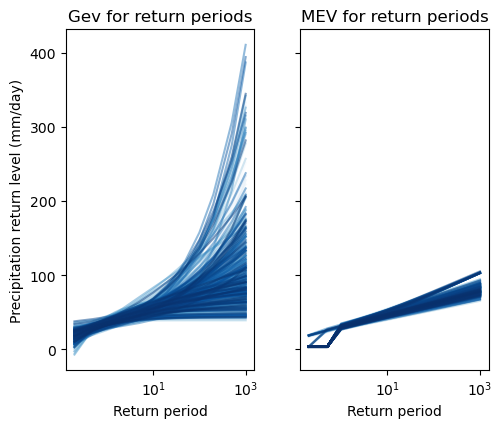

In [161]:
fig, [ax,ax2] = plt.subplots(1,2,figsize=(5,4), sharey=True)
fig.tight_layout()
for index, i in enumerate(concat_lst):
    i.Gev.plot(ax=ax,legend=False, color=cmap((index)/500),alpha=0.5)
ax.set_xscale('log')
ax.set_xlabel("Return period")
ax.set_ylabel("Precipitation return level (mm/day)")
ax.set_title("Gev for return periods")

for index,i in enumerate(concat_lst):
    i.Mev.plot(ax=ax2,legend=False,color=cmap((index)/500),alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel("Return period")
ax2.set_ylabel("Precipitation return level (mm/day)")
ax2.set_title("MEV for return periods")

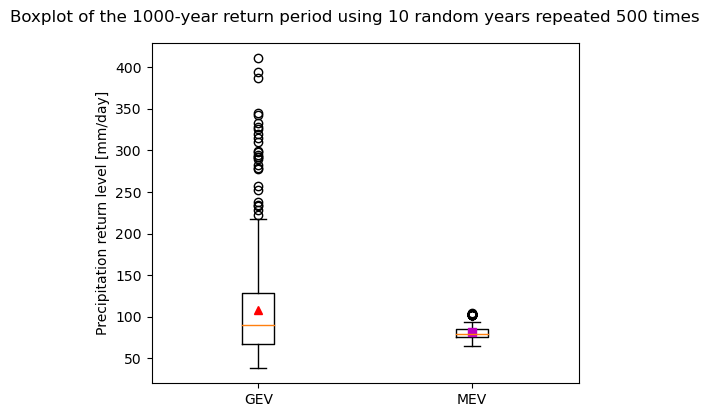

In [163]:
Tr = 1000
lst_series = []
for i in range(len(concat_lst)):
    val = concat_lst[i].loc[Tr]
    val.name=i
    lst_series.append(val)
df_tr = pd.concat(lst_series,axis=1).T

# exercise, plot the results of your testcase
boxplot_data = [df_tr.Gev.values, df_tr.Mev.values]

fig, ax = plt.subplots(1,figsize=(5,4))
fig.tight_layout(h_pad=2)

ax.boxplot(boxplot_data)
ax.plot(1, np.mean(boxplot_data[0]), marker='^', color='r', label='GEV estimate')
ax.plot(2, np.mean(boxplot_data[1]), marker='s', color='m', label='MEV estimate')
ax.xaxis.set_ticklabels(['GEV', 'MEV'])
ax.yaxis.set_label_text('Precipitation return level [mm/day]')
Tx = 1000
fig.suptitle('Boxplot of the ' + str(Tr) + '-year return period using ' 
          + str(nyears) + ' random years repeated ' + str(ntimes) + ' times', y=1.03);

Although they look the same, MEV has mushc less uncertainty